In [17]:
%load_ext autoreload
%autoreload 2

import cv2
import yaml
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import Image, display
from typing import List

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Experiments to visualize
exp_names = [
    "demo",
]

In [19]:
from utils.eval_utils import EditResultData

# Load all results
eval_dirs = sum([sorted([p for p in Path(f"result/{exp_name}").glob("*/") if p.is_dir()]) for exp_name in exp_names], [])
edit_results = [EditResultData.from_metrics(eval_dir, skip_img_load=True) for eval_dir in eval_dirs]

In [20]:
def get_metrics(edit_results: List[EditResultData]) -> pd.DataFrame:
    """Creates a pandas Dataframe for all experiments

    Args:
        edit_results (List[EditResultData]): Experiment results

    Returns:
        pd.DataFrame Results as pandas dataframe
    """

    data = []

    for r in tqdm(edit_results):
        method_cfg = {**r.method}

        metrics = {
            "data": str(r.data),
            "exp_name": r.exp_name,
            "method": method_cfg.pop("type"),
            "scheduler": method_cfg.pop("scheduler"),
            "steps": method_cfg.pop("num_inference_steps", 50),
            "edit_method": r.edit_method["type"],
            "method_cfg": method_cfg,
            **{k: v["mean"] for k, v in r.metrics.items()},
        }

        data.append(metrics)

    print(data)

    return pd.DataFrame(data)

df = get_metrics(edit_results)
df

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 28976.19it/s]

[{'data': 'pie', 'exp_name': 'result_demo', 'method': 'diffinv', 'scheduler': 'ddim', 'steps': 50, 'edit_method': 'simple', 'method_cfg': {}, 'clip_acc': 1.0, 'ssim': 0.45633868376413983, 'clip': 0.3306593596935272, 'clip_pix2pix': 0.2521158854166667, 'dinov2_vitb14': 0.011126234817008177, 'blipclip': 0.7769716580708822, 'nslpips': 0.4680623412132263, 'blipclip_acc': 1.0, 'lpips': 0.494489053885142, 'bglpips': 0.3035595118999481, 'msssim': 0.5611570576826731, 'dino_vitb8': 0.06991642465194066}, {'data': 'pie', 'exp_name': 'result_demo', 'method': 'npi', 'scheduler': 'ddim', 'steps': 50, 'edit_method': 'simple', 'method_cfg': {}, 'clip_acc': 1.0, 'ssim': 0.4788823624451955, 'clip': 0.3231954872608185, 'clip_pix2pix': 0.2523193359375, 'dinov2_vitb14': 0.013055479464431604, 'blipclip': 0.6783102750778198, 'nslpips': 0.5440137088298798, 'blipclip_acc': 1.0, 'lpips': 0.5744075179100037, 'bglpips': 0.3396368622779846, 'msssim': 0.4895307223002116, 'dino_vitb8': 0.09027076015869777}, {'data':

,data,exp_name,method,scheduler,steps,edit_method,method_cfg,clip_acc,ssim,clip,clip_pix2pix,dinov2_vitb14,blipclip,nslpips,blipclip_acc,lpips,bglpips,msssim,dino_vitb8
0,pie,result_demo,diffinv,ddim,50,simple,{},1.0,0.456339,0.330659,0.252116,0.011126,0.776972,0.468062,1.000000,0.494489,0.303560,0.561157,0.069916
1,pie,result_demo,npi,ddim,50,simple,{},1.0,0.478882,0.323195,0.252319,0.013055,0.678310,0.544014,1.000000,0.574408,0.339637,0.489531,0.090271
2,pie,result_demo,diffinv,ddim,50,ptp,{},1.0,0.495869,0.328198,0.270711,0.009072,0.759562,0.422163,0.666667,0.441814,0.282758,0.607757,0.055263
3,pie,result_demo,npi,ddim,50,ptp,{},1.0,0.721197,0.328070,0.258301,0.004731,0.832476,0.191447,0.666667,0.210291,0.100005,0.854436,0.018451


In [21]:
def get_metrics_per_image_single(exp: EditResultData) -> pd.DataFrame:
    """Get per image metrics for one experiment

    Args:
        exp (EditResultData): Result object to retrieve per image metrics for

    Returns:
        pd.DataFrame: Dataframe
    """

    out = []
    for i in range(len(exp)):
        sample = exp[i]
        out.append({
            **{k: sample[k] for k in ("image_file", "edit_image_file", "source_prompt", "target_prompt")},
            **sample["metrics"],
            "method": exp.method,
            "edit_method": exp.edit_method,
        })

    if len(out) == 0:
        return None

    out = pd.DataFrame(out)

    return out

def get_metrics_per_image(edit_results: List[EditResultData]) -> pd.DataFrame:
    """Get per image metrics for multiple experiment

    Args:
        edit_results (List[EditResultData]): Result objects to retrieve per image metrics for

    Returns:
        pd.DataFrame: Dataframes
    """
    
    out = [get_metrics_per_image_single(exp) for exp in edit_results]
    out = pd.concat([o for o in out if o is not None])

    return out

df_per_img = get_metrics_per_image(edit_results[:1])
df_per_img

,image_file,edit_image_file,source_prompt,target_prompt,clip_acc,ssim,clip,clip_pix2pix,dinov2_vitb14,blipclip,nslpips,blipclip_acc,lpips,bglpips,msssim,dino_vitb8,method,edit_method
0,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a slanted mountain bicycle on the road in fron...,a slanted rusty mountain bicycle on the road i...,1.0,0.371833,0.307944,0.156494,0.011618,0.763128,0.425705,1.0,0.438030,0.212372,0.471118,0.100908,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}
1,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a round cake with orange frosting on a wooden ...,a square cake with orange frosting on a wooden...,1.0,0.446330,0.358949,0.171143,0.010655,0.714637,0.554321,1.0,0.586513,0.422423,0.551758,0.048990,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}
2,data/eval/PIE-Bench_v1/annotation_images/0_ran...,result/demo/00_pie_test3_None_simple_ddim_diff...,a cat sitting on a wooden chair,a dog sitting on a wooden chair,1.0,0.550854,0.325085,0.428711,0.011106,0.853149,0.424161,1.0,0.458924,0.275883,0.660596,0.059851,"{'scheduler': 'ddim', 'type': 'diffinv'}",{'type': 'simple'}


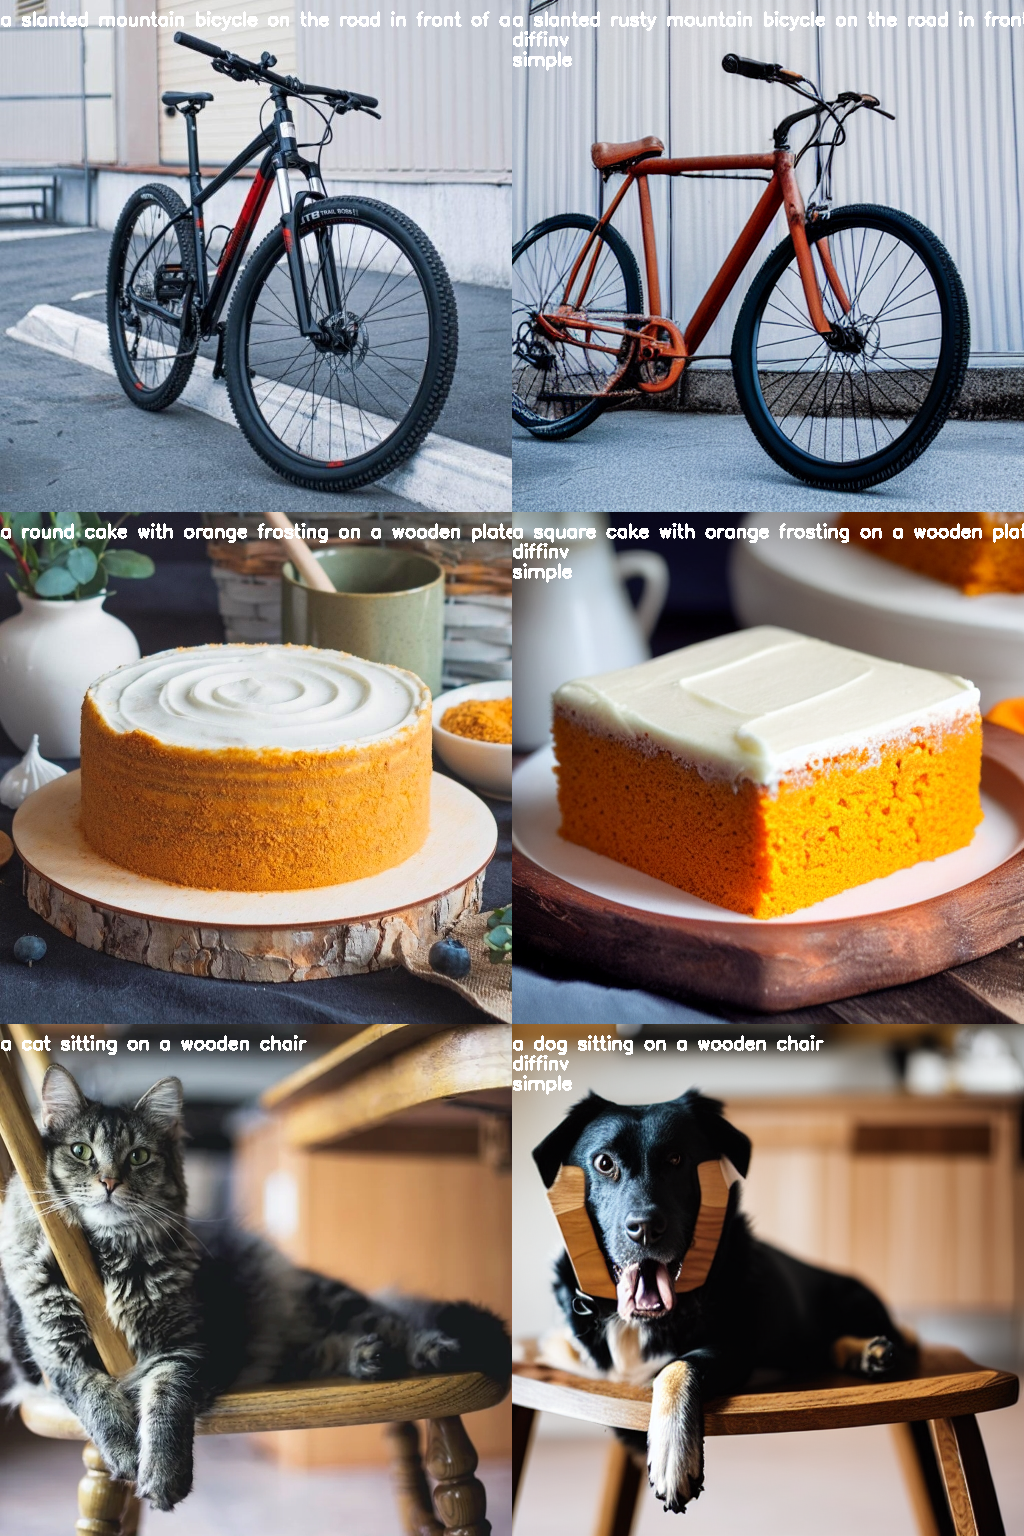

In [22]:
from utils.vis_utils import img_grid

def show_grid(entrys: pd.DataFrame, topk: int=5) -> "DisplayHandle":
    """Display a image grid of per image results.

    Args:
        entrys (pd.DataFrame): Per image dataframe
        topk (int, optional): How many entries to visualize. Defaults to 5.

    Returns:
        DisplayHandle: Image for notebook display
    """

    rows = []
    rows_titles = []

    def create_row(entry):
        rows.append([str(entry.image_file), str(entry.edit_image_file)])
        rows_titles.append([entry.source_prompt, "\n".join([entry.target_prompt, entry.method["type"], entry.edit_method["type"]])])

    for i in range(topk):
        create_row(entrys.iloc[i])

    out = img_grid(rows, rows_titles)
    return display(Image(cv2.imencode(".png", out)[1]))

show_grid(df_per_img, 3)